# Dataset presentation

This dataset contains country to country commercial exchanges over time.

Each record represents, for a given year, the two stakeholders and the amount of goods exchanged between them in current dollars.
The years go from 1870 to 2009.

The goal of this presentation is to show how the commercial exchanges evolved in the world between 1870 and 2009.

# Importing basic modules

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt


# Data wrangling and data loading

In [2]:
wholeData = pd.read_csv("worldExchangesWhole.csv")

Problem here, there are some missing values that are encoded as negative flows. We cannot afford to keep negative imports. So we first replace them with NaN.

In [3]:
wholeData.flow1 = wholeData.flow1.apply(lambda x:np.nan if x<0 else x)
wholeData.flow2 = wholeData.flow2.apply(lambda x:np.nan if x<0 else x)

Then, drop na, to have a smaller table with only relevant and clean data.

In [4]:
wholeData.dropna(inplace=True)
wholeData.shape

(540502, 5)

In [5]:
wholeData

,importer1,importer2,YEAR,flow1,flow2
0,United States of America,Canada,1920,611.86,735.48
1,United States of America,Canada,1921,335.44,442.99
2,United States of America,Canada,1922,364.02,502.84
3,United States of America,Canada,1923,416.00,598.14
4,United States of America,Canada,1924,399.14,496.32
...,...,...,...,...,...
791336,Tonga,Samoa,2005,1.88,0.65
791337,Tonga,Samoa,2006,2.32,0.80
791338,Tonga,Samoa,2007,2.88,0.99
791339,Tonga,Samoa,2008,3.29,1.13


Now, we will reshape our dataframe so that each record reflects one exchange with the two stakeholders.
It means we have to replicate each record that originally contains for each dyade their respective exchange amount.

In [6]:
df1=wholeData[["YEAR","importer1","importer2","flow1"]]
df1.columns=["YEAR","To","From","flow"]

df2=wholeData[["YEAR","importer2","importer1","flow2"]]
df2.columns=["YEAR","To","From","flow"]

wholeData = df1.append(df2,ignore_index=True)

Next, we need to associate coordinates with each country in the dyade. This way, Kepler.gl will know where to plot the edges we just gathered.

In [7]:
coords=pd.read_csv("worldcountriesgpscoord.csv",encoding="latin1")

wholeData = wholeData.merge(coords, left_on='From', right_on="name", left_index=True).drop('name',axis=1)
wholeData = wholeData.rename(columns={'latitude':'lat1','longitude':'long1'})

wholeData = wholeData.merge(coords, left_on='To', right_on="name", left_index=True).drop('name',axis=1)
wholeData = wholeData.rename(columns={'latitude':'lat2','longitude':'long2'})

wholeData=wholeData.reset_index()
wholeData


,index,YEAR,To,From,flow,lat1,long1,lat2,long2
0,227,1920,United States of America,Canada,611.86000,56.130366,-106.346771,37.090240,-95.712891
1,227,1921,United States of America,Canada,335.44000,56.130366,-106.346771,37.090240,-95.712891
2,227,1922,United States of America,Canada,364.02000,56.130366,-106.346771,37.090240,-95.712891
3,227,1923,United States of America,Canada,416.00000,56.130366,-106.346771,37.090240,-95.712891
4,227,1924,United States of America,Canada,399.14000,56.130366,-106.346771,37.090240,-95.712891
...,...,...,...,...,...,...,...,...,...
947693,139,2005,Marshall Islands,Taiwan,53.29977,23.697810,120.960515,7.131474,171.184478
947694,139,2006,Marshall Islands,Taiwan,104.40780,23.697810,120.960515,7.131474,171.184478
947695,92,2007,Hong Kong,Taiwan,37979.71000,23.697810,120.960515,22.396428,114.109497
947696,92,2008,Hong Kong,Taiwan,32689.90000,23.697810,120.960515,22.396428,114.109497


Now, let's filter out low values, so that we don't get overwhelmed with too much edges. In order to filter out the data, we first need to show how it is spread. Since we have hundreds of thousands of records, we cannot do boxplot. So we use the describe method of pandas dataframe.

In [8]:
wholeData.describe()

,index,YEAR,flow,lat1,long1,lat2,long2
count,947698.000000,947698.000000,9.476980e+05,947698.000000,947698.000000,947698.000000,947698.000000
mean,119.103314,1984.337487,1.703347e+02,20.398548,15.443493,20.398548,15.443493
std,68.692905,20.660474,2.705021e+03,25.050940,63.572034,25.050940,63.572034
min,0.000000,1870.000000,0.000000e+00,-40.900557,-175.198242,-40.900557,-175.198242
25%,58.000000,1973.000000,0.000000e+00,5.152149,-10.940835,5.152149,-10.940835
50%,114.000000,1989.000000,2.329641e-01,20.593684,18.490410,20.593684,18.490410
75%,175.000000,2000.000000,8.100000e+00,40.069099,45.079162,40.069099,45.079162
max,244.000000,2009.000000,1.198527e+06,64.963051,179.414413,64.963051,179.414413


Here, we can see that the mean is around 170 millions of current dollars. We will use mean as the threshold.

In [9]:
wholeData=wholeData[wholeData.flow>=170]#Remove only biggest exchanges

In [10]:
wholeData.shape

(65891, 9)

In [11]:
wholeData.describe()

,index,YEAR,flow,lat1,long1,lat2,long2
count,65891.000000,65891.000000,6.589100e+04,65891.000000,65891.000000,65891.000000,65891.000000
mean,116.782171,1994.167732,2.324743e+03,31.764861,24.147628,32.161050,22.728457
std,69.356168,14.008291,1.001229e+04,24.762004,66.699967,23.570004,65.344751
min,1.000000,1870.000000,1.700000e+02,-40.900557,-106.346771,-40.900557,-172.104629
25%,58.000000,1987.000000,2.828000e+02,23.424076,-3.435973,23.424076,-3.435973
50%,107.000000,1998.000000,5.406000e+02,37.090240,14.550072,37.090240,14.550072
75%,180.000000,2005.000000,1.484655e+03,50.503887,69.345116,49.817492,53.847818
max,244.000000,2009.000000,1.198527e+06,64.963051,179.414413,64.963051,179.414413


Now we will add a column for Kepler.gl to understand that year is actually a time feature, thus making time animation possible.

In [12]:
wholeData["DateTime"]=wholeData.YEAR.apply(lambda y:f"{y}-01-01T00:00:00")

<ipython-input-12-7160986b2f4c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wholeData["DateTime"]=wholeData.YEAR.apply(lambda y:f"{y}-01-01T00:00:00")


# Data exporting to visualization

Drop NA (last time, to make sure we don't have nas before exporting)

In [13]:
wholeData.dropna(inplace=True)

wholeData.to_csv("wholeData.csv")

<ipython-input-13-3a06026eed58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wholeData.dropna(inplace=True)


# Data analysis

Let's take a look at how much a given country exports (and how it evolves in time).
This gives us the total amount of exports for each country of origin.

In [14]:
exporters = wholeData.groupby(["YEAR","From"])["flow"].sum()
exporters = pd.DataFrame(exporters)
exporters = exporters.reset_index(level=['YEAR',"From"])


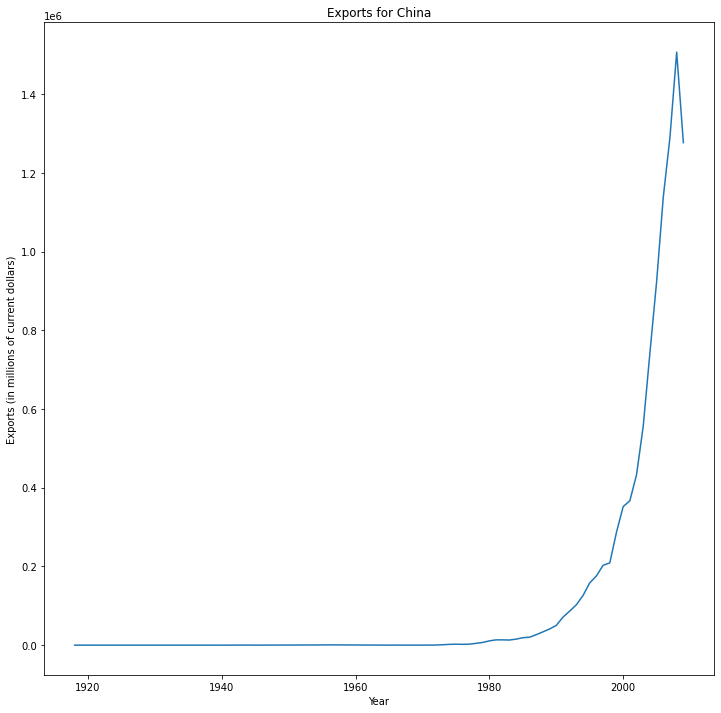

In [15]:
def plotCountryExports(countryName):
    plt.figure(figsize=(12,12))
    plt.title(f"Exports for {countryName}")
    plt.plot(exporters.YEAR[exporters.From==countryName],exporters.flow[exporters.From==countryName])
    plt.xlabel("Year")
    plt.ylabel("Exports (in millions of current dollars)")
    
plotCountryExports("China")

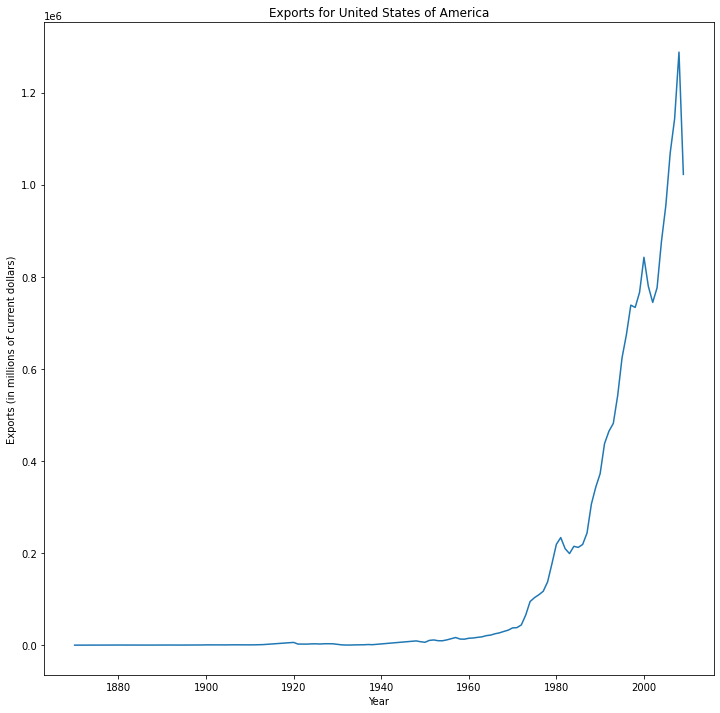

In [16]:
plotCountryExports("United States of America")

In [17]:
exporters

,YEAR,From,flow
0,1870,France,181.940
1,1870,United States of America,240.950
2,1871,United Kingdom,407.500
3,1871,United States of America,296.190
4,1872,France,202.920
...,...,...,...
5165,2009,Venezuela,53312.280
5166,2009,Vietnam,54370.882
5167,2009,Yemen,4627.380
5168,2009,Zambia,2017.420


In [18]:
exportersDegree = wholeData.groupby(["YEAR","From"])["flow"].count()
exportersDegree = pd.DataFrame(exportersDegree)
exportersDegree = exportersDegree.reset_index(level=['YEAR',"From"])
exportersDegree.columns =["YEAR","From","degree"]

In [19]:
def plotDegreeDistribution(year):
    degreeInYear = exportersDegree[exportersDegree.YEAR==year]
    degreeCount = degreeInYear.degree.value_counts().rename_axis('unique_values').reset_index(name='counts')
    plt.figure(figsize=(12,12))
    plt.plot(degreeCount.counts,degreeCount.unique_values)
    plt.xlabel("Degree of country node")
    plt.ylabel("Number of countries with such degree")
    plt.title(f"Degree distribution in {year}")
    

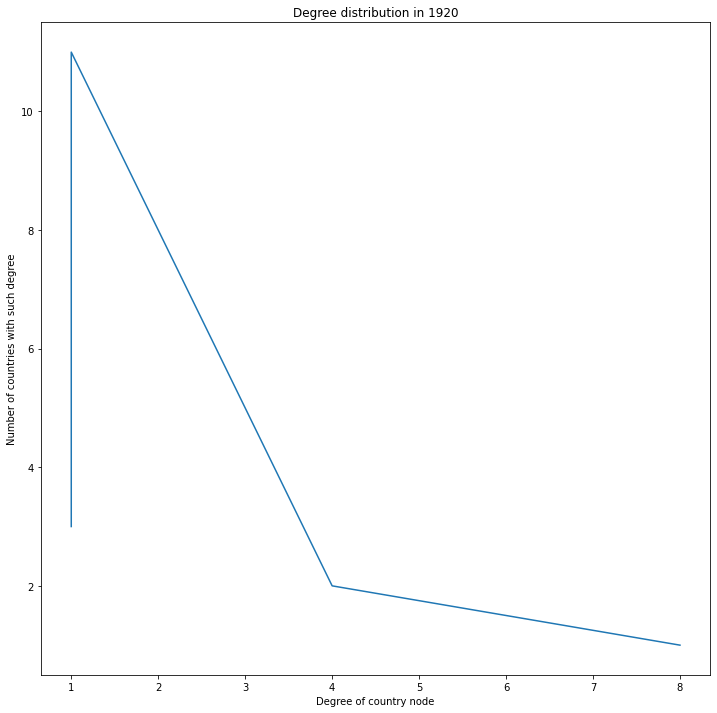

In [20]:
plotDegreeDistribution(1920)

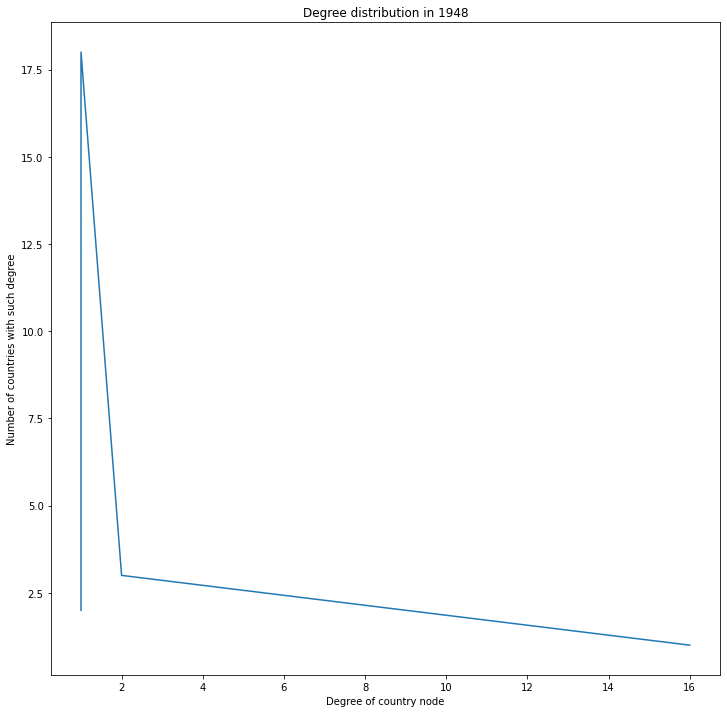

In [21]:
plotDegreeDistribution(1948)

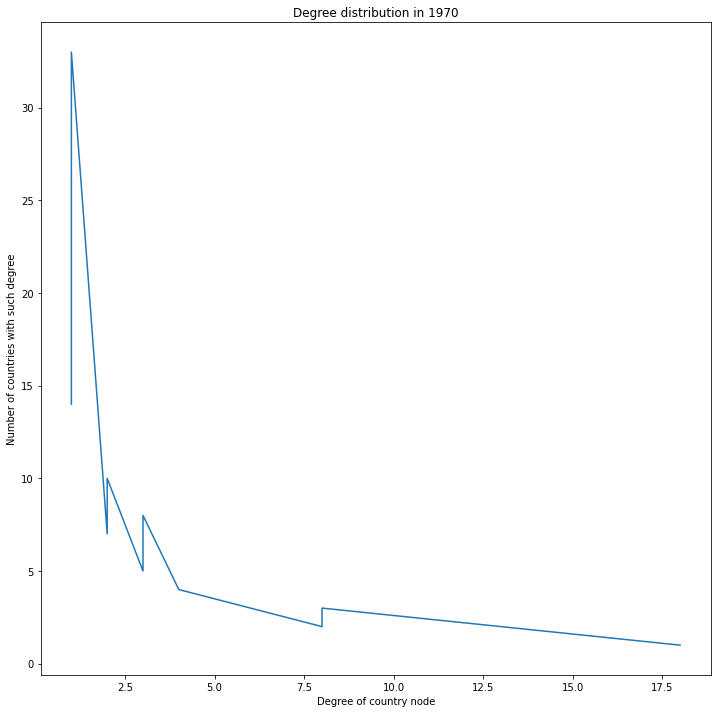

In [22]:
plotDegreeDistribution(1970)

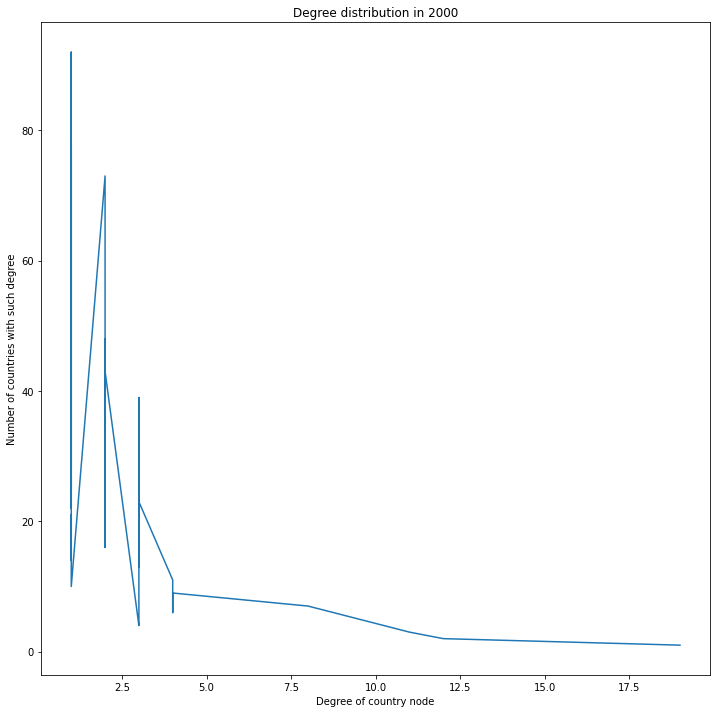

In [23]:
plotDegreeDistribution(2000)

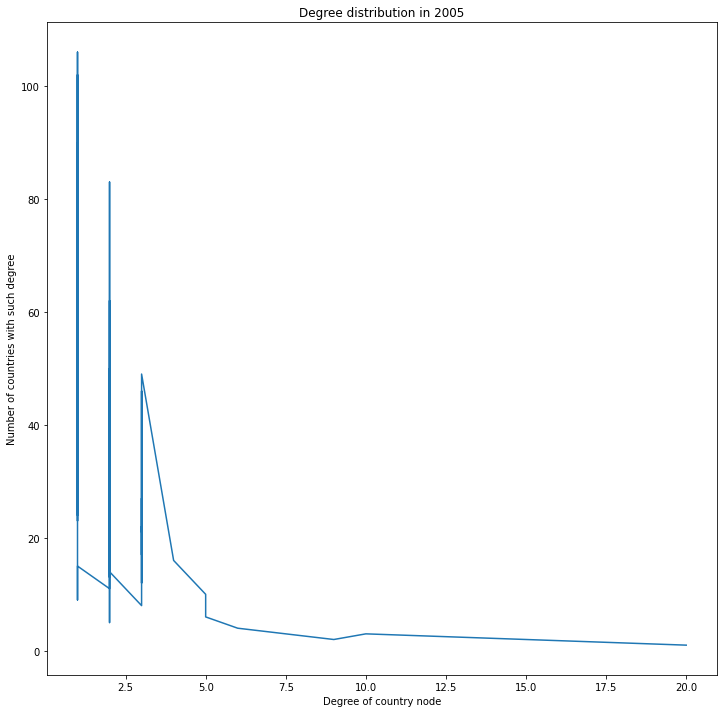

In [24]:
plotDegreeDistribution(2005)

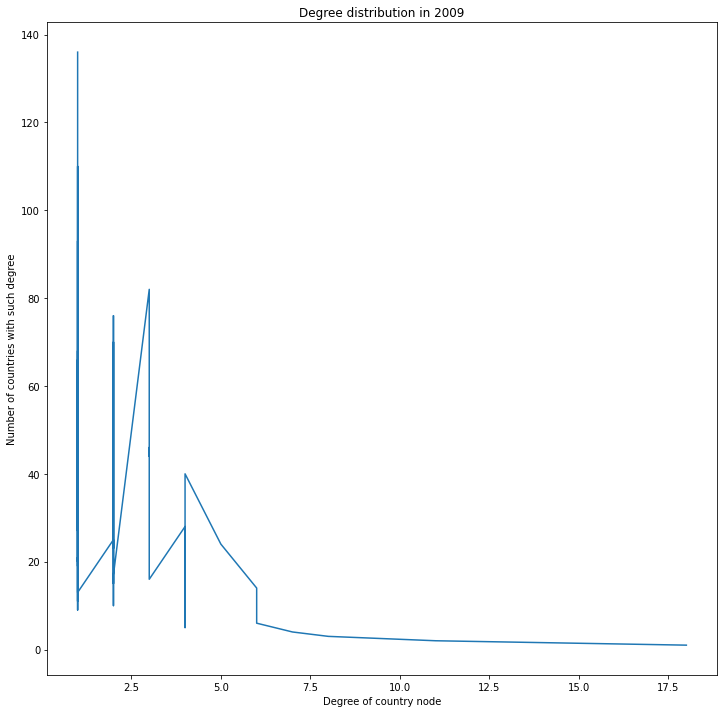

In [25]:
plotDegreeDistribution(2009)

In [26]:
exporters["DateTime"]=exporters.YEAR.apply(lambda y:f"{y}-01-01T00:00:00")
exporters.to_csv("exporters.csv")